In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH/ FILENAME).open('wb').write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)


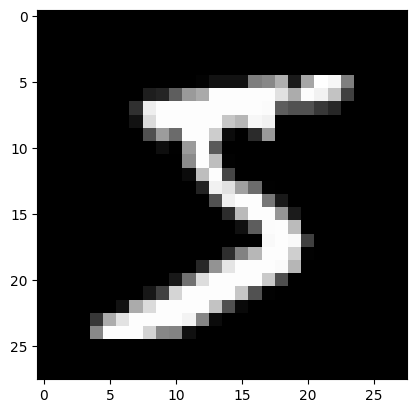

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

In [4]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
import math
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_(True)
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
  x_max = x.max(-1, keepdim=True).values
  x_shifted = x - x_max
  return x_shifted - x_shifted.exp().sum(-1, keepdim=True).log()

def model(xb):
  return log_softmax(xb @ weights + bias)

In [7]:
x = torch.tensor([
    [1, 2, 1,],
    [1, 10, 239],
])
log_softmax(x).exp()

tensor([[0.2119, 0.5761, 0.2119],
        [0.0000, 0.0000, 1.0000]])

In [8]:
bs = 64
xb = x_train[:bs] #mini_batch
preds =model(xb)
preds[0], preds.shape

(tensor([-2.3805, -2.9705, -2.2800, -2.4318, -2.6250, -2.2453, -1.9232, -2.8419,
         -2.0814, -1.8419], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [9]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

print(nll(log_softmax(x), torch.tensor([1, 2])).item())
print(nll(log_softmax(x), torch.tensor([1, 0])).item())

loss_func = nll

0.27572232484817505
119.27571868896484


In [10]:
yb = y_train[:bs]
print(loss_func(preds, yb))

tensor(2.3047, grad_fn=<NegBackward0>)


In [11]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [12]:
print(accuracy(preds, yb))

tensor(0.0625)


In [13]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2
for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    # set_trace()
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()

In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0788, grad_fn=<NegBackward0>) tensor(1.)


In [15]:
import torch.nn.functional as F
loss_func = F.cross_entropy

In [16]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0788, grad_fn=<NllLossBackward0>) tensor(1.)


In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))
  def forward(self, xb):
    return xb @ self.weights + self.bias

In [18]:
model = Mnist_Logistic()

In [19]:
print(loss_func(model(xb), yb))

tensor(2.2934, grad_fn=<NllLossBackward0>)


In [20]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()

fit()

In [21]:
print(loss_func(model(xb), yb))

tensor(0.0799, grad_fn=<NllLossBackward0>)


In [22]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [23]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3715, grad_fn=<NllLossBackward0>)


In [24]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0800, grad_fn=<NllLossBackward0>)


In [25]:
from torch import optim

In [26]:
def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs

    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]

    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3555, grad_fn=<NllLossBackward0>)
tensor(0.0811, grad_fn=<NllLossBackward0>)


In [27]:
from torch.utils.data import TensorDataset

In [28]:
train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0793, grad_fn=<NllLossBackward0>)


In [29]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=bs)

In [31]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0829, grad_fn=<NllLossBackward0>)


In [32]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [33]:
model, opt = get_model()
for epoch in range(epochs):
  model.train()

  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3281)
1 tensor(0.3110)


In [34]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss.item(), len(xb)

In [35]:
import numpy as np
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)
    model.eval()
    with torch.no_grad():
      losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb, None) for xb,yb in valid_dl]
      )

    val_loss = np.sum(np.multiply(losses, nums))
    print(epoch, val_loss)

In [36]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [37]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 3749.6639029979706
1 2998.8111582398415


In [38]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [39]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 3538.835186958313
1 2597.8982281684875


In [41]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [42]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 3932.6445693969727
1 2733.508100748062


In [43]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [44]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [45]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 3810.886214494705
1 2354.3313003778458


In [46]:
# If the current accelerator is available, we will use it. Otherwise, we use the CPU.
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [47]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(device), y.to(device)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [48]:
model.to(device)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [49]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2405.425872325897
1 2035.5381470024586
